#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

from sklearn.metrics import mean_squared_error

OSError: dlopen(/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/lib/lib_lightgbm.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib
  Referenced from: <D3923ACB-D836-32D3-A031-CF91999FDAFC> /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/lib/lib_lightgbm.dylib
  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file)

## Подготовка

In [ ]:
data = pd.read_csv('/datasets/taxi.csv',  parse_dates=['datetime'], index_col='datetime')
data.sort_index(inplace=True)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


__Описание данных:__
* datetime - время заказа
* num_orders - число заказов

Сделаем ресемплирование по одному часу.

In [ ]:
data = data.resample('1H').sum()

In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

In [ ]:
data['mean'] = data['num_orders'].shift(fill_value=0).rolling(35).mean()
data['std'] = data['num_orders'].shift(fill_value=0).rolling(35).std()

<AxesSubplot:xlabel='datetime'>

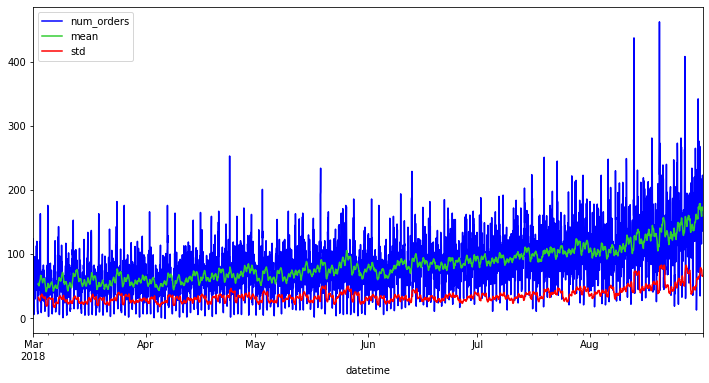

In [ ]:
data.plot(figsize=(12, 6), color=['blue', 'limegreen', 'red'])

### Тест Дики — Фуллера

In [ ]:
test = adfuller(data['num_orders'])
print('ADF Statistic:', test[0])
print('p-value:', test[1])
print('Critical Values:', test[4])

if test[0] < test[4]['1%']:
    print('Ряд стационарен')
else:
    print('Ряд не стационарен')

ADF Statistic: -3.0689242890279558
p-value: 0.028940051402612906
Critical Values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Ряд не стационарен


### Разложение временного ряда на тренд, сезонность и остатки

In [ ]:
data = data.fillna(data['num_orders'].mean())

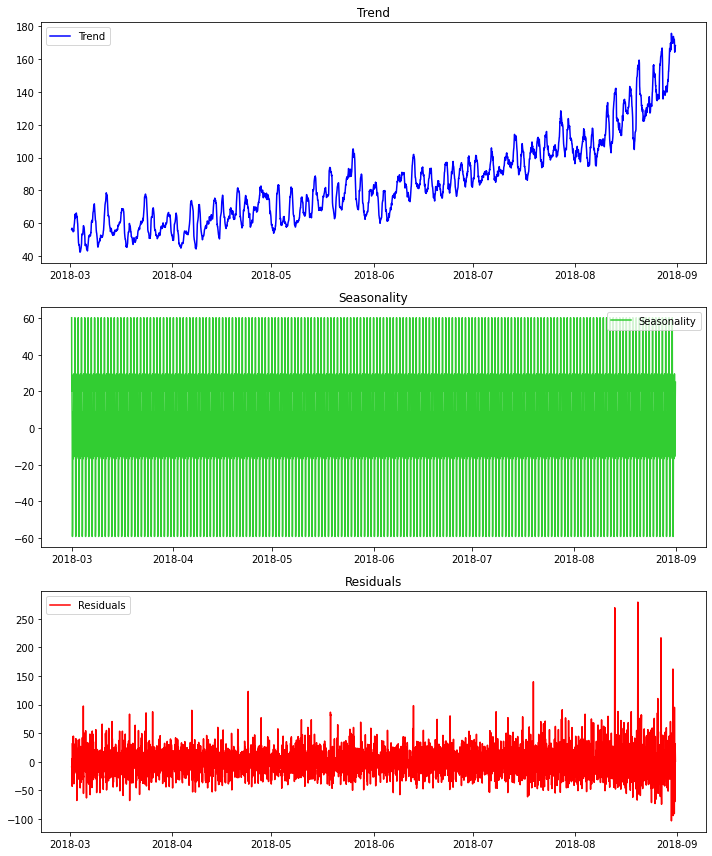

In [ ]:
decomposed = seasonal_decompose(data['num_orders'], model='additive')

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

ax[0].plot(decomposed.trend, label='Trend', color='blue')
ax[0].set_title('Trend')
ax[0].legend()

ax[1].plot(decomposed.seasonal, label='Seasonality', color='limegreen')
ax[1].set_title('Seasonality')
ax[1].legend()

ax[2].plot(decomposed.resid, label='Residuals', color='red')
ax[2].set_title('Residuals')
ax[2].legend()

plt.tight_layout()
plt.show()

На графике тренда видим постепенное увеличение. Это говорит о росте спроса на такси. Сезонность имеет равномерное распределение, значит, явных паттернов не наблюдается. Остатки колеблются вокруг нуля, это указывает на то, что модель тренда и сезонности хорошо описывает данные. В конце графика остатков наблюдаются колебания, это может говорить об изменении данных в последние периоды, что может повлиять на итоговое качество модели

In [ ]:
daily_data = data.resample('D').mean()

### Анализ недельной сезонности

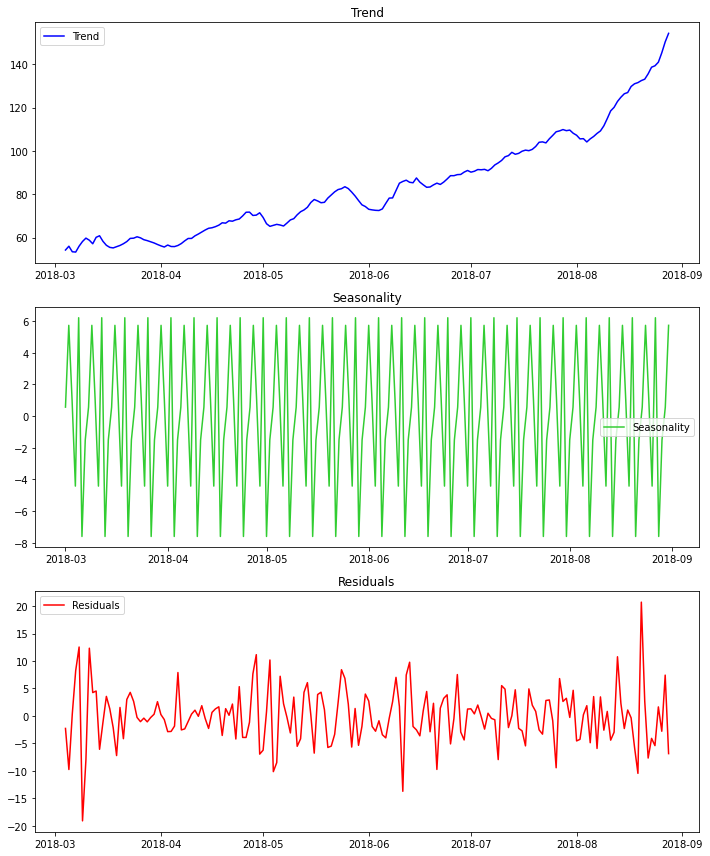

In [ ]:
decomposed = seasonal_decompose(daily_data['num_orders'], model='additive')

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

ax[0].plot(decomposed.trend, label='Trend', color='blue')
ax[0].set_title('Trend')
ax[0].legend()

ax[1].plot(decomposed.seasonal, label='Seasonality', color='limegreen')
ax[1].set_title('Seasonality')
ax[1].legend()

ax[2].plot(decomposed.resid, label='Residuals', color='red')
ax[2].set_title('Residuals')
ax[2].legend()

plt.tight_layout()
plt.show()

Наблюдается рост спроса на такси с каждым днем. На графике сезонности видим несколько колебаний в течение одного дня. Это может говорить о часовых колебаниях: в определенные часы дня количество заказов сильно варьируется. 

### Новые признаки

In [ ]:
data = data.drop(['mean', 'std'], axis=1)

In [ ]:
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek

In [ ]:
for lag in range(1, 11):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

In [ ]:
data.dropna(inplace=True)

In [ ]:
data['year'].unique()

array([2018])

In [ ]:
data = data.drop('year', axis=1)

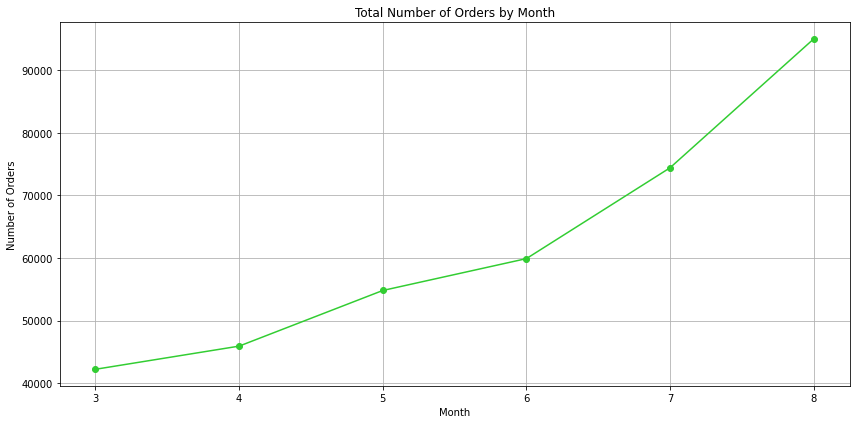

In [ ]:
monthly_aggregation = data.groupby('month')['num_orders'].sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_aggregation.index.astype(str), monthly_aggregation, color='limegreen', marker='o')

plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.title('Total Number of Orders by Month')

plt.xticks()
plt.grid(True)

plt.tight_layout()
plt.show()

Наблюдается рост спроса каждый месяц. Признак является неинформативным

In [ ]:
data = data.drop('month', axis=1)

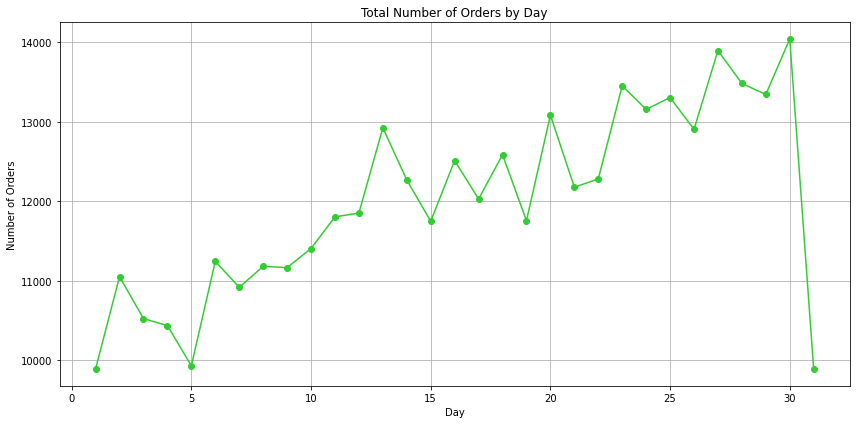

In [ ]:
daily_aggregation = data.groupby('day')['num_orders'].sum()

plt.figure(figsize=(12, 6))
plt.plot(daily_aggregation.index, daily_aggregation, color='limegreen', marker='o')

plt.xlabel('Day')
plt.ylabel('Number of Orders')
plt.title('Total Number of Orders by Day')
plt.xticks()
plt.grid(True)

plt.tight_layout()
plt.show()

Видим постепенный рост количества заказов, как и в графике по месяцам, он обусловлен общим ростом спроса

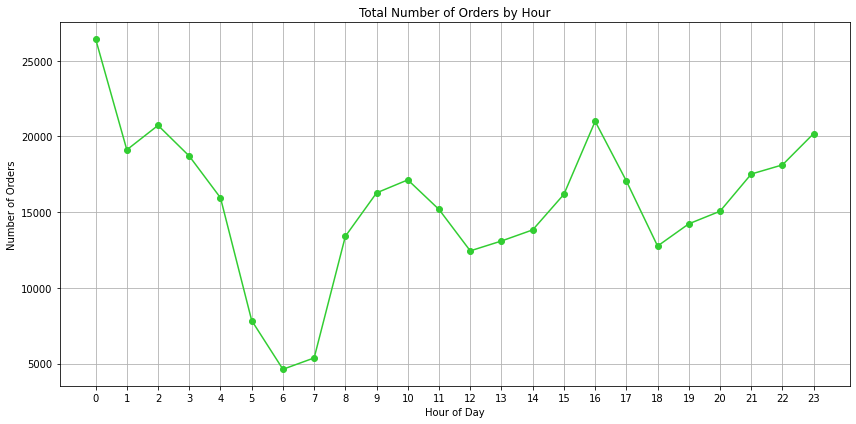

In [ ]:
hourly_aggregation = data.groupby('hour')['num_orders'].sum()

plt.figure(figsize=(12, 6))
plt.plot(hourly_aggregation.index, hourly_aggregation, color='limegreen', marker='o')

plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.title('Total Number of Orders by Hour')
plt.xticks(range(24)) 
plt.grid(True)

plt.tight_layout()
plt.show()

Наибольший спрос в вечернее и ночное время. Пики активности - 00:00, 2:00, 16:00

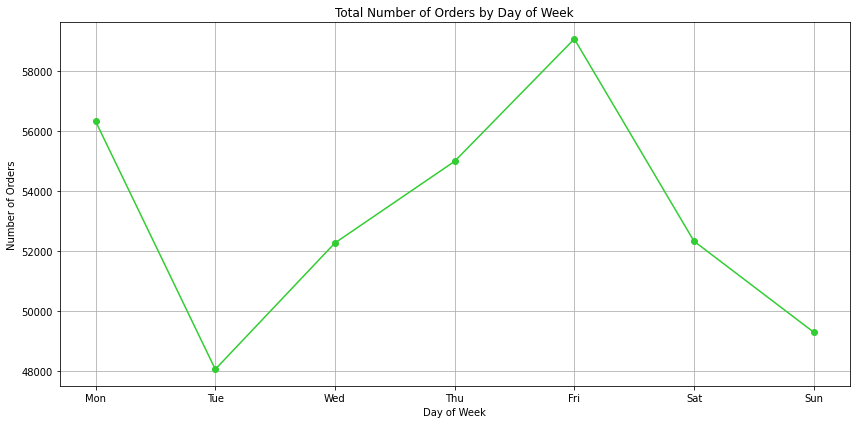

In [ ]:
weekday_aggregation = data.groupby('day_of_week')['num_orders'].sum()

plt.figure(figsize=(12, 6))
plt.plot(weekday_aggregation.index, weekday_aggregation, color='limegreen', marker='o')

plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.title('Total Number of Orders by Day of Week')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True)

plt.tight_layout()
plt.show()

Наибольшая активность наблюдается в пятницу, а наименьшая во вторник

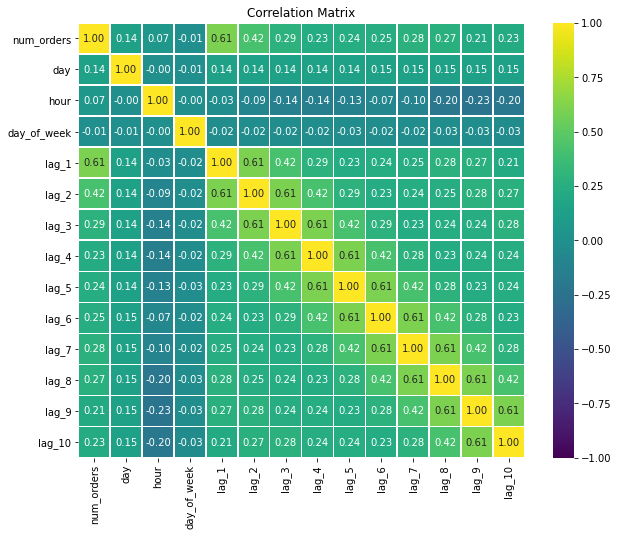

In [ ]:
correlation_matrix = data.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


## Обучение

In [ ]:
data.head()

,num_orders,day,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
datetime,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,1,10,3,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-01 11:00:00,96,1,11,3,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-01 12:00:00,30,1,12,3,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-01 13:00:00,32,1,13,3,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-01 14:00:00,48,1,14,3,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


In [ ]:
train, test = train_test_split(data, test_size=0.1, shuffle=False)

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [ ]:
train.index[-1], test.index[0]

(Timestamp('2018-08-13 14:00:00', freq='H'),
 Timestamp('2018-08-13 15:00:00', freq='H'))

### Random Forest

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')

In [ ]:
%%time
grid_search.fit(X_train, y_train)

CPU times: user 53.1 s, sys: 218 ms, total: 53.3 s
Wall time: 53.4 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error')

In [ ]:
rf_model = grid_search.best_estimator_
rf_model

RandomForestRegressor(max_depth=20, min_samples_leaf=2, random_state=42)

In [ ]:
np.sqrt(-grid_search.best_score_)

26.236554955280152

### CatBoost

In [ ]:
Cat_model = CatBoostRegressor(loss_function="RMSE", logging_level='Silent') 

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.4],
    'depth': [4, 6, 8],
    'iterations': [50, 100]
}

grid_search = GridSearchCV(estimator=Cat_model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1, verbose=0)

In [ ]:
%%time
grid_search.fit(X_train, y_train)

CPU times: user 24.5 s, sys: 857 ms, total: 25.4 s
Wall time: 1min 22s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fb692297bb0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'iterations': [50, 100],
                         'learning_rate': [0.01, 0.1, 0.2, 0.4]},
             scoring='neg_root_mean_squared_error')

In [ ]:
Cat_model = grid_search.best_estimator_
grid_search.best_params_

{'depth': 4, 'iterations': 100, 'learning_rate': 0.2}

In [ ]:
-grid_search.best_score_

25.95452926479832

### LightGBM 

In [ ]:
lgb_model = lgb.LGBMRegressor(objective='rmse')

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.4],
    'num_leaves': [5, 10],
    'max_depth': [5, 10, 15, 20]
}

grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1, verbose=1)

In [ ]:
%%time
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
CPU times: user 54.8 s, sys: 426 ms, total: 55.3 s
Wall time: 55.8 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(objective='rmse'), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.4],
                         'max_depth': [5, 10, 15, 20], 'num_leaves': [5, 10]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [ ]:
lgb_model = grid_search.best_estimator_
lgb_model

LGBMRegressor(max_depth=5, num_leaves=10, objective='rmse')

In [ ]:
-grid_search.best_score_

25.95298538624088

### Выбор лучшей модели

* Быстрее всего параметры были подобраны для CatBoost
* Лучшая метрика на тренировочной выборке - 26, модель - LightGBM

__ИТОГ__:

Лучшая модель - __LightGBM__ с гиперпараметрами: max_depth=20, min_samples_leaf=4

## Тестирование

In [ ]:
y_pred = lgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Модель: Random Forest. Метрика: {rmse}')

Модель: Random Forest. Метрика: 44.16239193334917


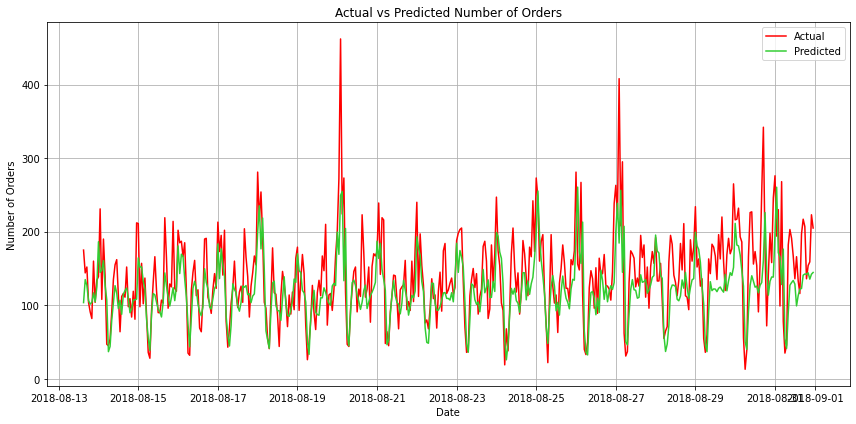

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(y_test.index, y_test, label='Actual', color='red')
plt.plot(y_test.index, y_pred, label='Predicted', color='limegreen')

plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.title('Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

__ВЫВОД__:

По графику видно, что хуже всего модель предсказывает пиковые значения спроса и количество заказов в конце временного интервала